# Time series prediction using LSTM

## Dataset
- Daily minimum temperatures in Melbourne, Australia, 1981-1990
- Units: Degrees Celcius

## Question 1

In [88]:
# All import statements.
import tensorflow as tf
import os
import math
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras  import callbacks
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error

### Load the data
- load daily-minimum-temperatures-in-me.csv

In [2]:
# run this cell to to mount the google drive if you are using google colab
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/My Drive/assignments/'

Mounted at /content/drive


In [4]:
data = pd.read_csv(project_path+'daily-minimum-temperatures-in-me.csv')

In [5]:
data.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


### Print the data
- First 5 rows only

In [10]:
data.head(5)

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


### Set index column
- Set the DataFrame index using "Date" column

In [15]:
data = data.set_index('Date')

In [16]:
data.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


## Question 2

### Check the total count of null values in the data

In [13]:
data.isnull().sum()

Date           0
Temperature    0
dtype: int64

### Drop all the rows with null values
- use dropna() method

In [18]:
data = data.dropna()

## Question 3

### Describe your dataframe
- use describe() method

In [19]:
data.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


### Plot the dataframe
- use plot() method

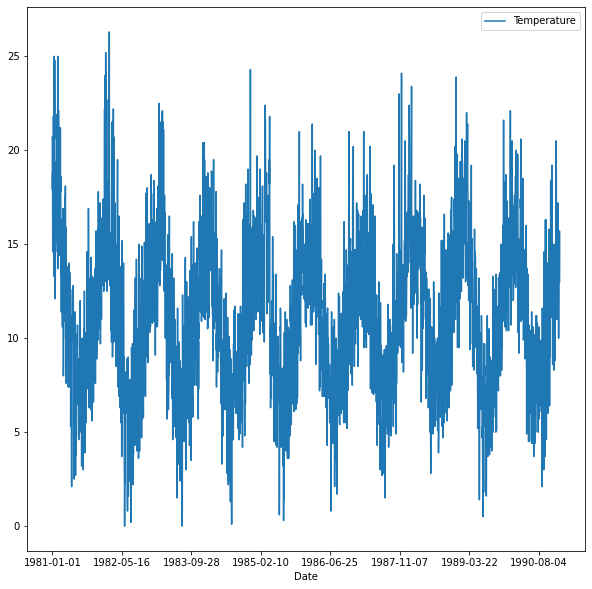

In [25]:
data.plot(figsize=(10,10))

### Get representation of the distribution of data using histogram
- use hist() method

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7eea594860>]],
      dtype=object)

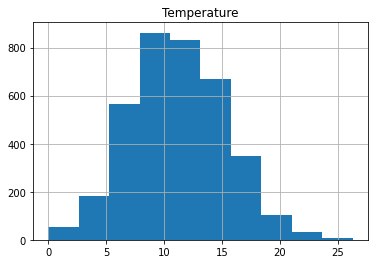

In [23]:
data.hist()

### Check minimum and maximum temperature
- use min() and max() methods

In [21]:
data.min()

Temperature    0.0
dtype: float64

Minimum temperature is 0.0

In [22]:
data.max()

Temperature    26.3
dtype: float64

Maximum temperature is 26.3

## Question 4

### Split the dataset into training and testing
- training data: 75%
- testing data: 25%

In [101]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
train  = data[0:train_size]
test = data[train_size: len(data)]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2737
test: 913


In [102]:
train.shape

(2737, 1)

In [103]:
test.shape

(913, 1)

### Normalize the data
- normalize temperature values using MinMaxScaler
- feature_range: 0-1
- fit MinMaxScaler on train data and transform it
  - use fit_transform() method
- transform test data using MinMaxScaler object
  - use transform() method

In [104]:
scaler = MinMaxScaler(feature_range=(0,1))

In [105]:
train_trans = scaler.fit_transform(train)

In [106]:
test_trans = scaler.transform(test)

### Print scaled train and test data
- print only first 5 values

In [107]:
print(train_trans[:5])

[[0.78707224]
 [0.68060837]
 [0.7148289 ]
 [0.55513308]
 [0.60076046]]


In [108]:
print(test_trans[:5])

[[0.22813688]
 [0.22053232]
 [0.18631179]
 [0.19011407]
 [0.31939163]]


## Question 5

### Create sequential data
Map the temperature at a particular day 'd' to the temperature at day t
'd+n', where n is any number you define.

For example: to map temperatures of consecutive days, use d+1, i.e. lookback = 1
- Below function takes data as input and returns sequential data.
- X as features and y as labels

In [109]:
import numpy as np
def create_seq_data(data, lookback=1):
  X, y = list(), list()
  
  for day in range((len(data)-lookback)):
    X.append(data[day: day+lookback, 0])
    y.append(data[day+lookback, 0])
  return np.array(X), np.array(y)

### Use the above function to create train and test sets
- Get X_train and y_train
- Get X_test and y_test
- lookback = 1

In [110]:
X_train, y_train = create_seq_data(train_trans, 1)
X_test, y_test = create_seq_data(test_trans, 1)

### Reshape the data
- Reshape X_train and X_test
- use np.reshape() method
- this is to be done to make the data ready for input in model

In [111]:
# Needs to be reshaped as the model needs in this format
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Print shape of data
- print shape of X_train and X_test

In [112]:
print(X_train.shape)
print(X_test.shape)

(2736, 1, 1)
(912, 1, 1)


## Question 6

### Define sequential model
- initialize a Sequential model
- add an LSTM layer
  - units: 10
  - stateful: True
  - pass a `batch_input_shape` argument to your layer
  - batch_input_shape: (batch_size, look_back, 1)
    - batch_size: 1
    - look_back: 1
- add Dense layer with 1 neuron

In [113]:
#create Model using LSTM
batch_size = 1
look_back = 1
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1)) # For the 1 temperature to be predicted.

## Question 7

### compile your model
- loss: mean_squared_error
- optimizer: adam

In [114]:
model.compile(loss='mean_squared_error', optimizer='adam')

### summarize your model
- use summary() method

In [115]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 10)                   480       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


## Question 8

### fit your model
- epochs: 50
- batch_size: 1

In [116]:
model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/50
2736/2736 - 6s - loss: 0.0194
Epoch 2/50
2736/2736 - 6s - loss: 0.0103
Epoch 3/50
2736/2736 - 6s - loss: 0.0101
Epoch 4/50
2736/2736 - 6s - loss: 0.0101
Epoch 5/50
2736/2736 - 6s - loss: 0.0101
Epoch 6/50
2736/2736 - 6s - loss: 0.0100
Epoch 7/50
2736/2736 - 6s - loss: 0.0101
Epoch 8/50
2736/2736 - 6s - loss: 0.0100
Epoch 9/50
2736/2736 - 6s - loss: 0.0100
Epoch 10/50
2736/2736 - 6s - loss: 0.0100
Epoch 11/50
2736/2736 - 6s - loss: 0.0100
Epoch 12/50
2736/2736 - 6s - loss: 0.0099
Epoch 13/50
2736/2736 - 6s - loss: 0.0099
Epoch 14/50
2736/2736 - 6s - loss: 0.0099
Epoch 15/50
2736/2736 - 6s - loss: 0.0100
Epoch 16/50
2736/2736 - 6s - loss: 0.0099
Epoch 17/50
2736/2736 - 6s - loss: 0.0099
Epoch 18/50
2736/2736 - 6s - loss: 0.0099
Epoch 19/50
2736/2736 - 6s - loss: 0.0099
Epoch 20/50
2736/2736 - 6s - loss: 0.0099
Epoch 21/50
2736/2736 - 6s - loss: 0.0099
Epoch 22/50
2736/2736 - 6s - loss: 0.0100
Epoch 23/50
2736/2736 - 6s - loss: 0.0099
Epoch 24/50
2736/2736 - 6s - loss: 0.0100
E

## Question 9

### make predictions on train data
- use predict() method
  - batch_size: 1
- store predictions in a variable

In [117]:
predictions_train = model.predict(X_train, batch_size=1)

In [118]:
predictions_train

array([[0.678016  ],
       [0.61264616],
       [0.6430285 ],
       ...,
       [0.3787272 ],
       [0.28286195],
       [0.36287534]], dtype=float32)

### reset model state
- if you are using stateful=True in your model then you should call reset_states every time, when you want to make consecutive model calls independent.
- use reset_states() method

In [119]:
model.reset_states()

### make predictions on test data
- use predict() method
  - batch_size: 1
- store predictions in a variable

In [120]:
predictions_test = model.predict(X_test, batch_size=1)

In [121]:
predictions_test

array([[0.23009267],
       [0.24772438],
       [0.22293866],
       [0.2226907 ],
       [0.32281896],
       [0.4427396 ],
       [0.4682048 ],
       [0.42620587],
       [0.28844732],
       [0.30431488],
       [0.44386804],
       [0.2903618 ],
       [0.30470693],
       [0.3753059 ],
       [0.23830345],
       [0.2664572 ],
       [0.3159974 ],
       [0.3281687 ],
       [0.3598718 ],
       [0.36622936],
       [0.25109196],
       [0.28869683],
       [0.33222103],
       [0.33504853],
       [0.32742888],
       [0.33578527],
       [0.36818638],
       [0.37167066],
       [0.29495358],
       [0.3317592 ],
       [0.35411924],
       [0.3740548 ],
       [0.32417607],
       [0.36256254],
       [0.37905902],
       [0.23542848],
       [0.2790706 ],
       [0.2837691 ],
       [0.28352633],
       [0.33793473],
       [0.35402292],
       [0.2031059 ],
       [0.2228131 ],
       [0.32900178],
       [0.42814013],
       [0.44677454],
       [0.45837688],
       [0.386

## Question 10

### Inverse train predictions and true labels
- use your MinMaxSclarer object
- use inverse_transform() method

In [122]:
predictions_train = scaler.inverse_transform(predictions_train)
y_train = scaler.inverse_transform([y_train])

In [123]:
predictions_train[:5]

array([[17.831821],
       [16.112595],
       [16.91165 ],
       [13.892606],
       [14.730079]], dtype=float32)

In [124]:
y_train[:5]

array([[17.9, 18.8, 14.6, ...,  6.7,  9.4,  9.3]])

### Inverse test predictions and true labels
- use your MinMaxSclarer object
- use inverse_transform() method

In [125]:
predictions_test = scaler.inverse_transform(predictions_test)
y_test = scaler.inverse_transform([y_test])

In [126]:
y_test

array([[ 5.8,  4.9,  5. ,  8.4, 12.3, 13. , 11.4,  6.8,  7.6, 12.4,  7.1,
         7.5, 10. ,  5.3,  6.3,  8. ,  8.3,  9.3,  9.5,  5.6,  7. ,  8.5,
         8.5,  8.2,  8.5,  9.6,  9.7,  7.1,  8.4,  9.2,  9.8,  8.1,  9.4,
        10. ,  5.1,  6.7,  6.9,  6.8,  8.6,  9.1,  3.9,  4.8,  8.4, 11.6,
        12.1, 12.4, 10. , 10.1,  9.7, 11.7,  7.9,  8.6,  7.7,  5.8,  8.7,
        10.6,  6.7,  8.8,  9.7,  9. , 11.8, 15.2, 10. , 10.5,  5.5,  9.4,
         8.8,  5.3, 13. , 15.2, 13.2, 11.5,  6.8,  4.7,  5.2,  6.8, 10.7,
        10.1, 10. ,  9.8,  5.5, 13.5, 16.6,  8.4,  8.2, 11.1, 10.8,  8.8,
        10.8,  8.7, 12.4,  9. , 13.5, 14.7, 10.9,  8.5,  6. , 12.7, 11.1,
         8.7, 12.3, 13.3,  5.6, 13.7,  8.5, 11.2,  8.7, 11.7, 12.5,  8.2,
        15.6, 10.3, 11.4,  9.7,  6.3, 14.3, 11.3,  7.3, 12.8, 11.9, 14.3,
        11.6, 13.2, 15.5, 14.1,  9.5,  7.2, 11.8, 16.8, 12.5,  9.4, 11.9,
        10.3, 16.9, 17.5,  7.5,  8.6, 11.1, 11.5, 10.7, 15.7, 12.8, 13. ,
        12.9, 14.3, 13.7, 12.1, 11.9, 

In [127]:
predictions_train[:5]

array([[17.831821],
       [16.112595],
       [16.91165 ],
       [13.892606],
       [14.730079]], dtype=float32)

### Evaluate train predictions
- calculate RMSE
- RMSE = sqrt(mean_squared_error(true_labels, predicted_labels))
- use sqrt() and mean_squared_error() method
- print training RMSE

In [129]:
trainScore = math.sqrt(mean_squared_error(y_train[0], predictions_train[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 2.60 RMSE


### Evaluate test predictions
- calculate RMSE
- RMSE = sqrt(mean_squared_error(true_labels, predicted_labels))
- use sqrt() and mean_squared_error() method
- print testing RMSE

In [131]:
testScore = math.sqrt(mean_squared_error(y_test[0], predictions_test[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 2.53 RMSE
